# Phonological features

This notebook explores what the trained phoneme-level models learn about phonological features. I break this down into four questions:

1. Do the models learn representations that are functionally equivalent to phonological features?
2. Do they learn similar (i.e. globally comparable) representations?
3. Do they learn interpretable representations?
4. Do they structure the space in a similar way to phonological features?

I answer each of these questions using various analyses, mostly with structural methods. I am also interested in how the answers to these questions vary with the following properties:

- Training size
- Epoch
- Language
- Model
- Dimensionality

In [1]:
%load_ext blackcellmagic
import os
from utils import ROOT
os.chdir(ROOT)
from models import all_trained_phoneme_models, performance
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel, spearmanr
from tqdm import tqdm

sns.set()

In [2]:
# Add training size data
def training_size(lg):
    filename = f"data/phoneme/wikipron/{lg}/train.txt"
    if not os.path.exists(filename):
        filename = f"data/phoneme/wikipron/{lg.split('_')[0]}/train.txt"
    with open(filename) as file:
        contents = file.read()
    return contents.count("\n") + 1

## Do the models learn representations that are functionally equivalent to phonological features?

To answer this question, I compare the intrinsic performance of the language models that learn their own representations and those that use ground truth representations. If the models that learn their own representations perform similarly to those that use ground truth representations, then this would suggest that the learnt representations are "doing the job" of the ground truth representations. If however the ground truth models perform much better than the learnt models, this would suggest the models are not learning functionally equivalent representations. As a measure of intrinsic performance, I use the perplexity on the test set.

In [3]:
# Read in performance results
models = all_trained_phoneme_models()
results = []
for model in tqdm(models):
    # intrinsic performance (perplexity) only makes sense for true language models,
    # which in my case are the RNN models
    if "hidden" in model:
        model["ppl"] = performance(**model)
        results.append(model)
df = pd.DataFrame(results)
for column in ["level", "lg", "name"]:
    df[column] = df[column].astype("category")
for column in ["hidden", "epoch"]:
    df[column] = df[column].astype(int)
uses_ground_truth = df["size"] == "groundTruth"
ground_truth = df[uses_ground_truth]
learnt = df[~uses_ground_truth]
merged = pd.merge(
    learnt,
    ground_truth,
    on=["level", "lg", "name", "hidden", "epoch"],
    how="inner",
    suffixes=("_learnt", "_true"),
)
merged["size_learnt"] = merged["size_learnt"].astype(int)
merged["ppl_delta"] = merged["ppl_true"] - merged["ppl_learnt"]
merged["ppl_delta_percent"] = (merged["ppl_delta"] / merged["ppl_true"]) * 100

# Add training size data
def training_size(lg):
    filename = f"data/phoneme/wikipron/{lg}/train.txt"
    if not os.path.exists(filename):
        filename = f"data/phoneme/wikipron/{lg.split('_')[0]}/train.txt"
    with open(filename) as file:
        contents = file.read()
    return contents.count("\n") + 1
        

merged["n"] = merged["lg"].apply(training_size)
merged

100%|██████████| 82429/82429 [01:18<00:00, 1050.87it/s]


,level,lg,name,size_learnt,hidden,epoch,ppl_learnt,size_true,ppl_true,ppl_delta,ppl_delta_percent,n
0,old,cat,rnn,30,20,0,19.150223,groundTruth,19.880260,0.730038,3.672174,43200
1,old,cat,rnn,20,20,0,18.970442,groundTruth,19.880260,0.909819,4.576493,43200
2,old,cat,rnn,10,20,0,21.144991,groundTruth,19.880260,-1.264730,-6.361740,43200
3,old,cat,rnn,5,20,0,20.440744,groundTruth,19.880260,-0.560484,-2.819299,43200
4,old,cat,rnn,30,20,1,17.279394,groundTruth,18.229013,0.949619,5.209384,43200
...,...,...,...,...,...,...,...,...,...,...,...,...
49161,phoneme,afr,lstm,5,50,8,12.898238,groundTruth,12.584450,-0.313788,-2.493462,1031
49162,phoneme,afr,lstm,30,50,9,11.695046,groundTruth,12.342327,0.647281,5.244397,1031
49163,phoneme,afr,lstm,20,50,9,11.589212,groundTruth,12.342327,0.753115,6.101886,1031
49164,phoneme,afr,lstm,10,50,9,12.751270,groundTruth,12.342327,-0.408943,-3.313339,1031


In [23]:
def relationship_between_performance_delta_and_hyperparams(sizes, hiddens, names):
    # Restrict analysis to certain models
    size_restriction = merged["size_learnt"].isin(sizes)
    hidden_restriction = merged["hidden"].isin(hiddens)
    model_restriction = merged["name"].isin(names)
    subset = merged[size_restriction & hidden_restriction & model_restriction]
    performance_delta_by_lg = subset.groupby("lg")[["ppl_delta_percent", "n"]].mean()
    fig, ax = plt.subplots(figsize=(14, 10))
    grid = sns.scatterplot(data=performance_delta_by_lg, x="n", y="ppl_delta_percent", ax=ax)
    grid.set(xscale="log")
    grid.set_ylabel("Difference in perplexity", fontsize=20)
    grid.set_xlabel("Training size", fontsize=20)
    return grid

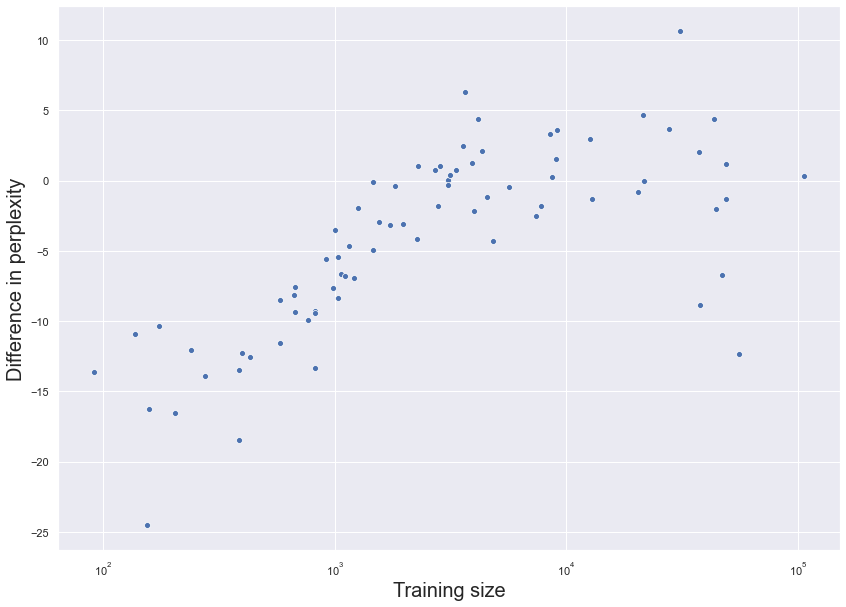

In [24]:
relationship_between_performance_delta_and_hyperparams(
    [5, 10, 20, 30], [10, 20, 30, 50], ["rnn", "lstm", "gru"]
);

Relationship between training data size and relative improvement when using learnt representations. Positive values on the Y axis indicate improved performance when using learnt representations over using ground truth representations. There is a clear upward trend showing that the use of learnt representations improves performance as a function of the training size. When there is small amounts of training data, learning representations degrades performance. When there is sufficient training data, learning representations is superior to the featural representations. This suggests that the learnt representations are functionally equivalent to the explicit representations. This is consistent with a similar result in Pimentel et al. (2020).

The plots below probe the robustness of this result by subsetting the analysis. We see that the same trend holds true when subsetted by the dimensionality of the embeddings and the hidden layer, as well as the model class.

In [71]:
# Explore the above relationship in subsets

def horizontal_mean_line(x, **kwargs):
    plt.axhline(x.mean(), linestyle = '-', color = 'maroon')




def relationship_between_performance_delta_and_hyperparams_subset(
    sizes, hiddens, names, by
):
    # Restrict analysis to certain models
    size_restriction = merged["size_learnt"].isin(sizes)
    hidden_restriction = merged["hidden"].isin(hiddens)
    model_restriction = merged["name"].isin(names)
    subset = merged[size_restriction & hidden_restriction & model_restriction]
    performance_delta_by_lg = (
        subset.groupby(["lg", by])[["ppl_delta_percent", "n"]].mean().reset_index()
    )
    grid = sns.FacetGrid(data=performance_delta_by_lg, col=by, col_wrap=2, height=10)
    grid = grid.map(sns.scatterplot, "n", "ppl_delta_percent")
    grid.map(horizontal_mean_line, 'ppl_delta_percent')
    grid.set(xscale="log")
    for ax in grid.axes.flat:
        title = ax.get_title()
        dim = title.split("=")[1].strip()
        new_title = f"{dim} dimensions"
        ax.set_title(new_title, fontsize=20)
        ax.set_ylabel("Difference in perplexity", fontsize=20)
        ax.set_xlabel("Training size", fontsize=20)
    return grid

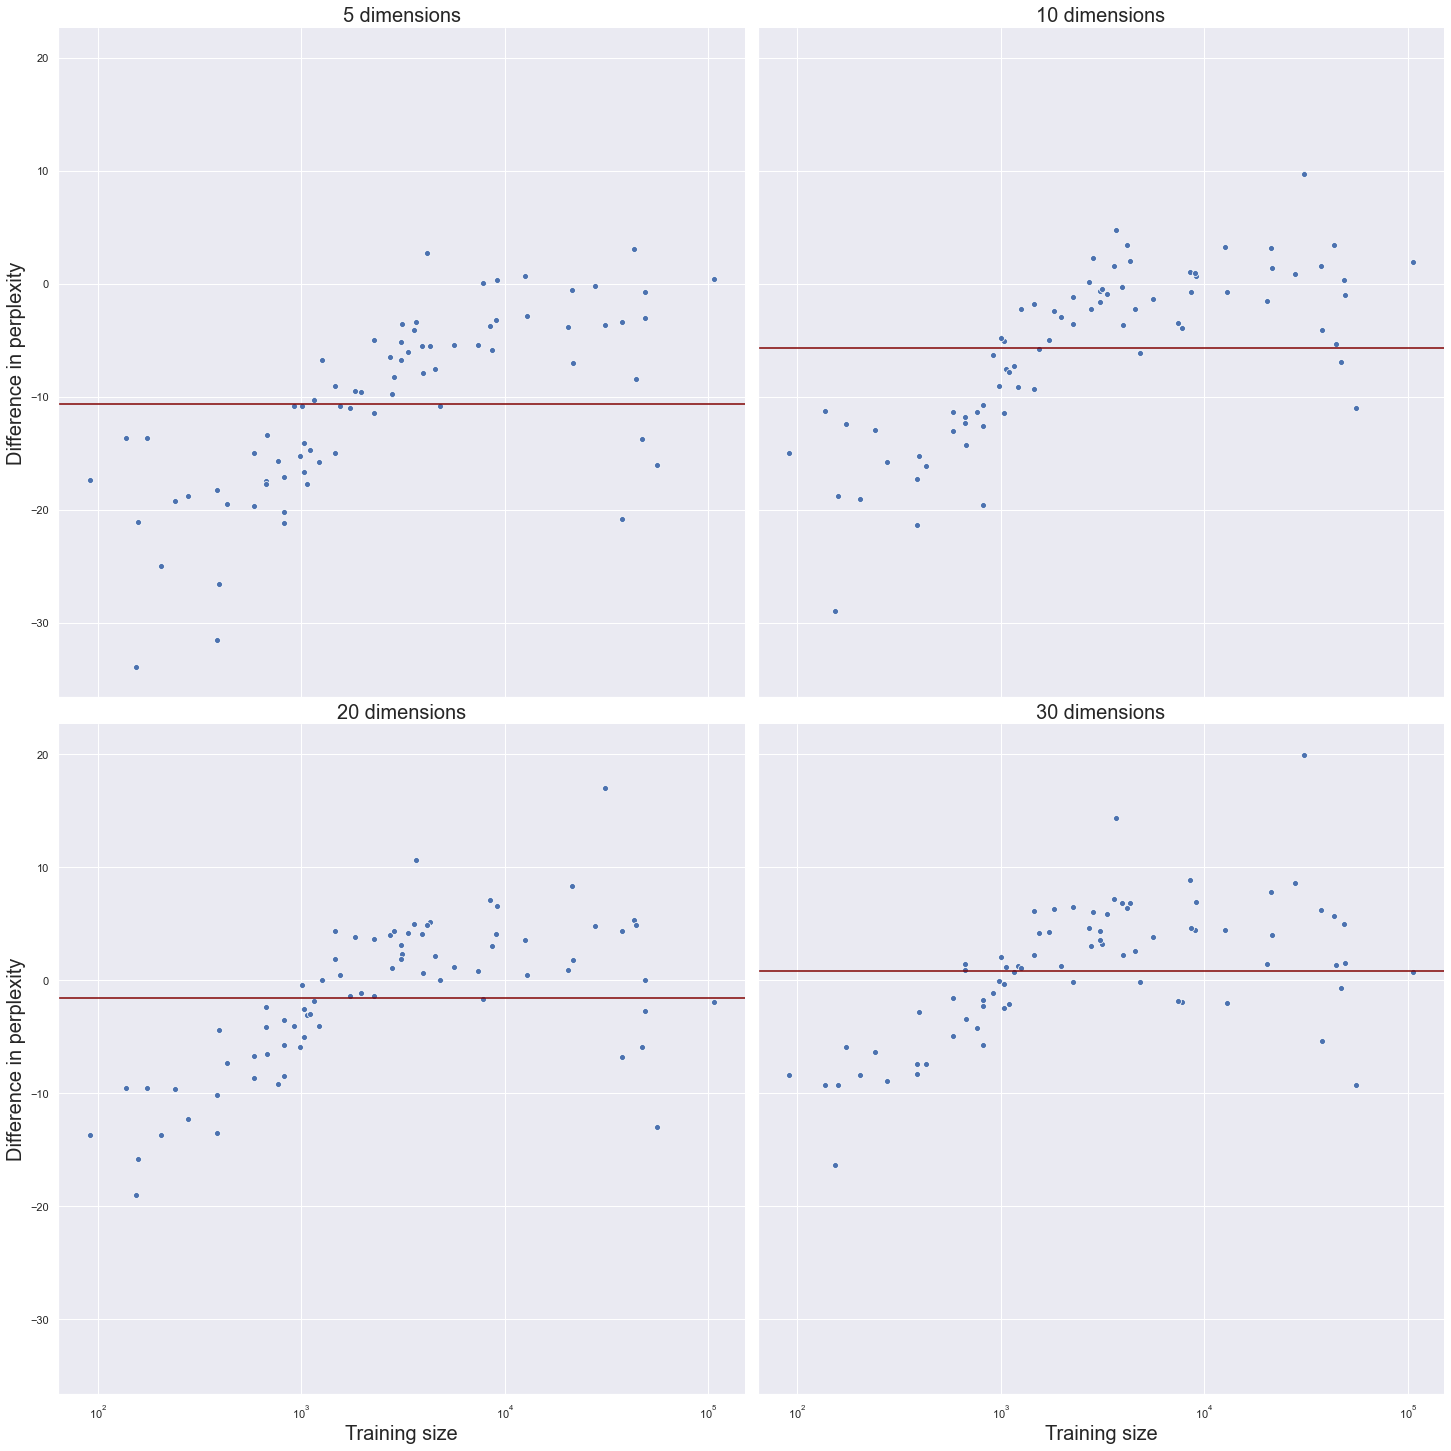

In [72]:
relationship_between_performance_delta_and_hyperparams_subset(
    [5, 10, 20, 30], [10, 20, 30, 50], ["rnn", "lstm", "gru"], "size_learnt"
);

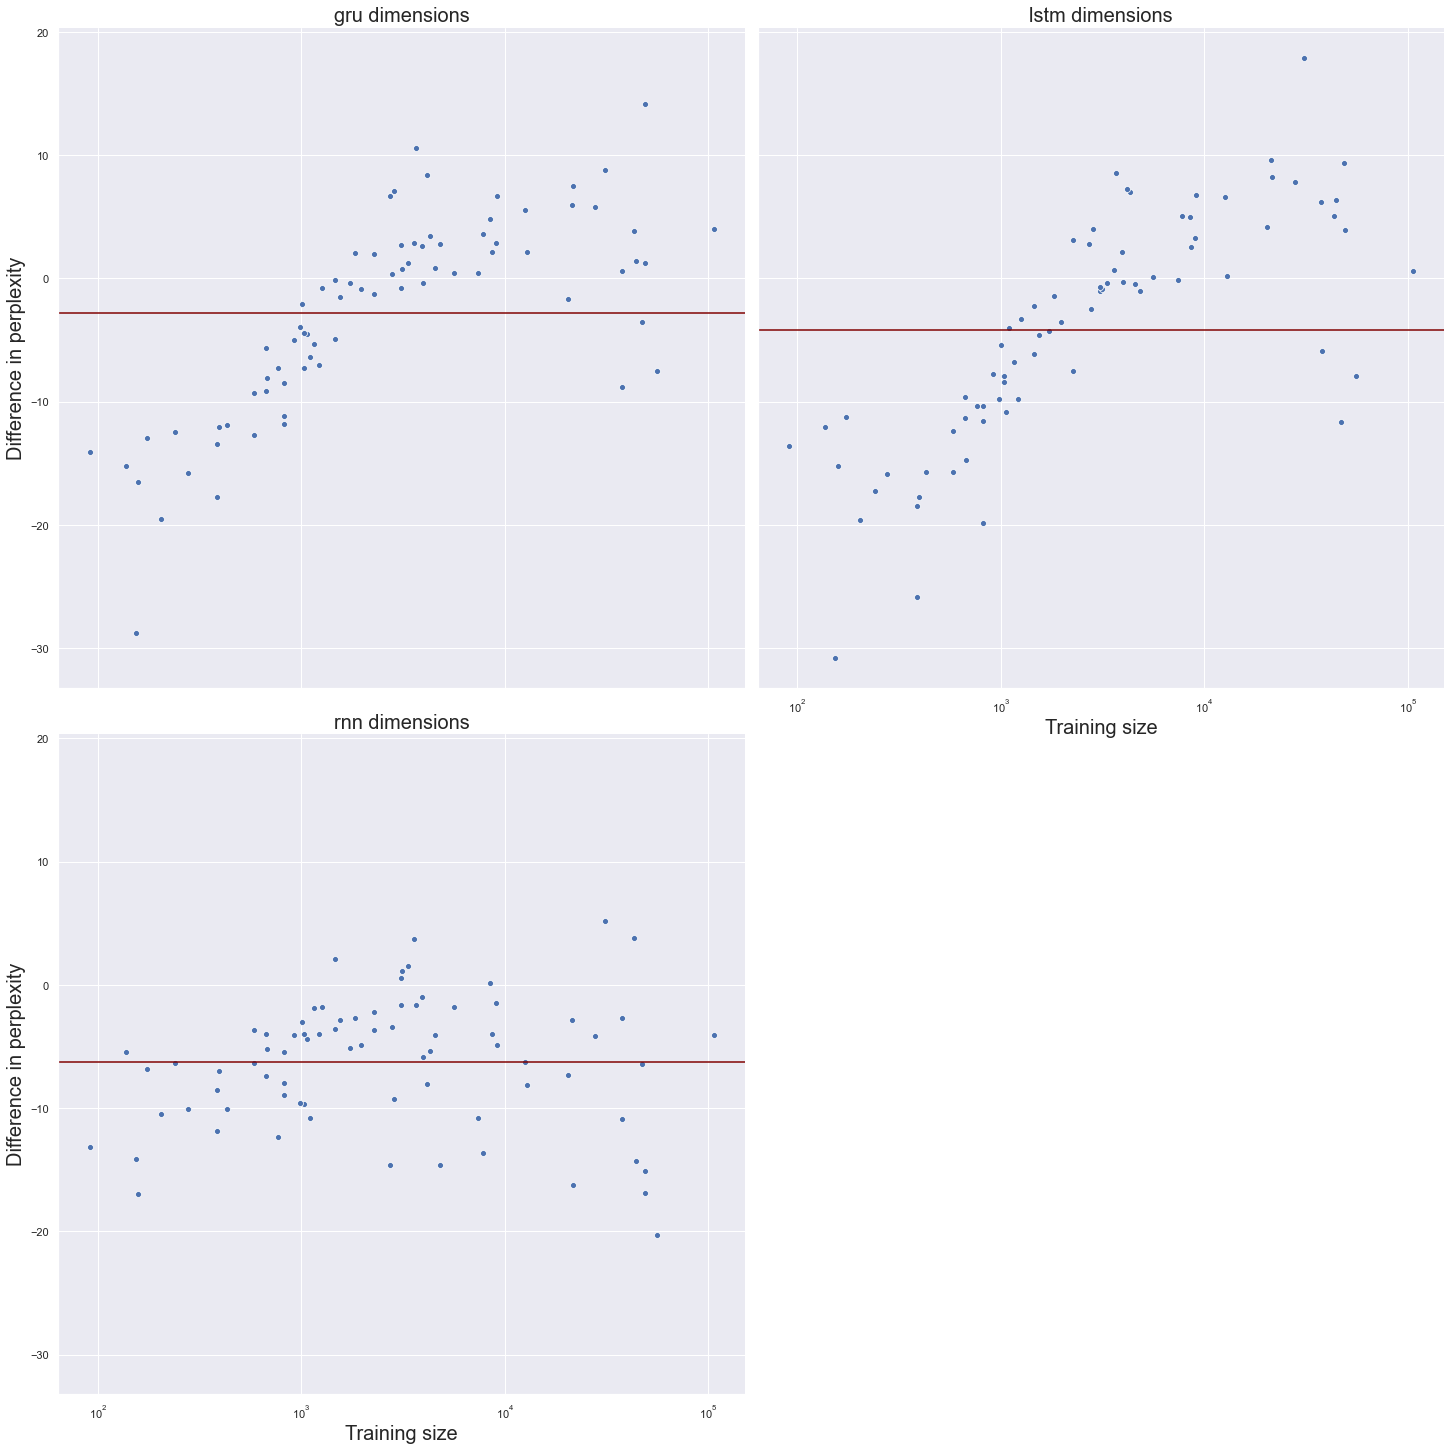

In [73]:
relationship_between_performance_delta_and_hyperparams_subset(
    [5, 10, 20, 30], [10, 20, 30, 50], ["rnn", "lstm", "gru"], "name"
);

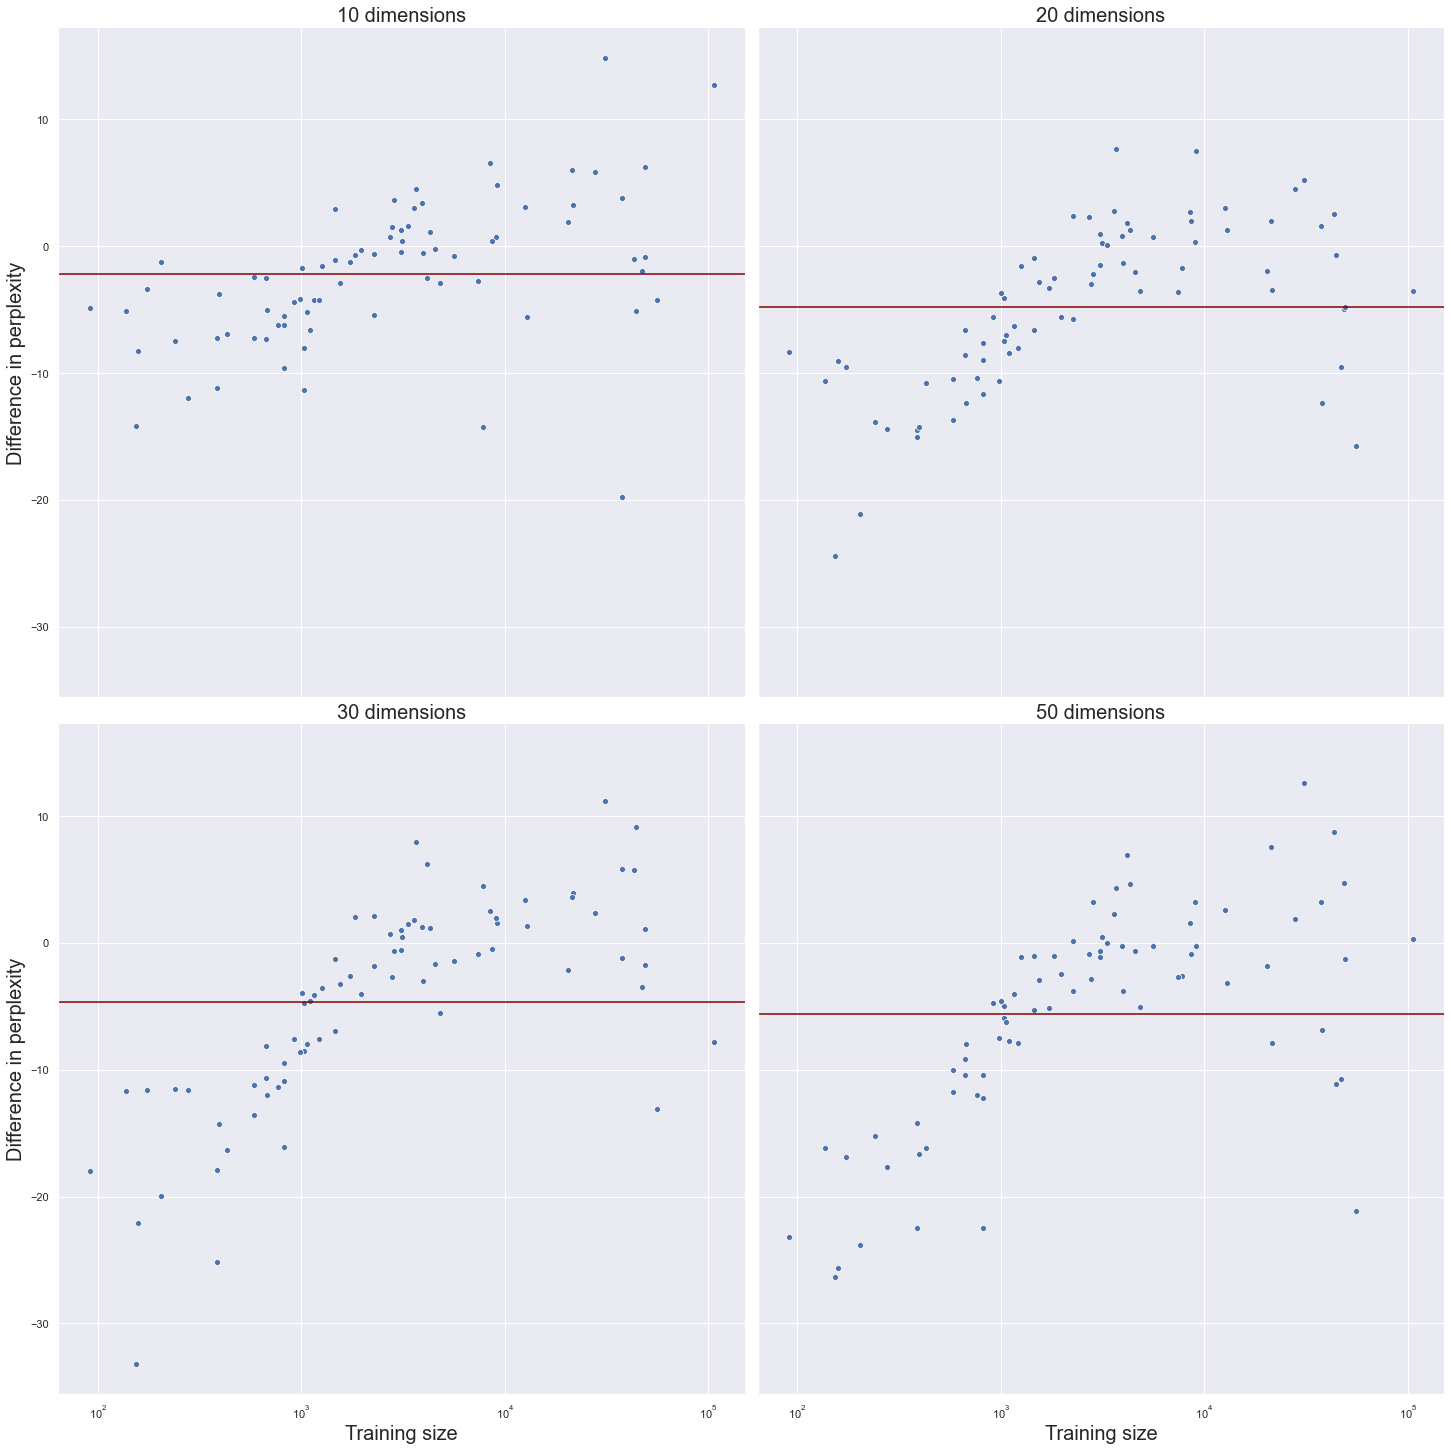

In [74]:
relationship_between_performance_delta_and_hyperparams_subset(
    [5, 10, 20, 30], [10, 20, 30, 50], ["rnn", "lstm", "gru"], "hidden"
);

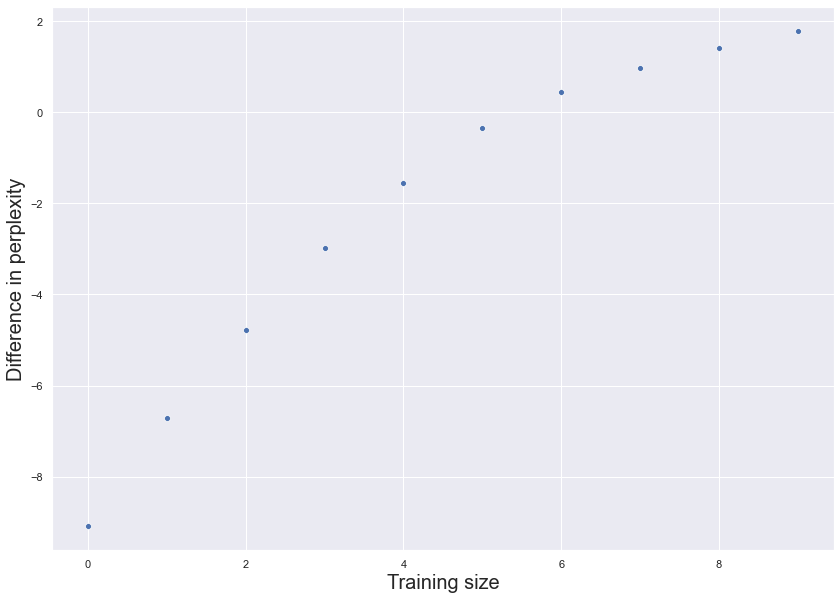

In [82]:
# Explore the above relationship by epoch
sizes = [5, 10, 20, 30]
hiddens = [10, 20, 30, 50]
names = ["rnn", "lstm", "gru"]
threshold = 500
# Restrict analysis to certain models
size_restriction = merged["size_learnt"].isin(sizes)
hidden_restriction = merged["hidden"].isin(hiddens)
model_restriction = merged["name"].isin(names)
threshold_restriction = merged["n"] > threshold
subset = merged[size_restriction & hidden_restriction & model_restriction & threshold_restriction]
performance_delta_by_lg = (
    subset.groupby("epoch")[["ppl_delta_percent", "n"]].mean().reset_index()
)
fig, ax = plt.subplots(figsize=(14, 10))
grid = sns.scatterplot(data=performance_delta_by_lg, x="epoch", y="ppl_delta_percent",ax=ax);
grid.set_ylabel("Difference in perplexity", fontsize=20)
grid.set_xlabel("Training size", fontsize=20);

This plot shows that the result holds across epochs as well. That is, the longer you train, the more improvement you get from learning your own representations.

## Do they learn similar (i.e. globally comparable) representations?

Here, I'm interested in whether the representations as a whole are comparable in similarity space to ground truth representations. This is a global measure of human-likeness. This is a first test of how human-like the representations are. You could imagine the models learn completely wacky unhuman-like representations that still manage to work, or that they are learning something close to humans.

In [119]:
# Read in correlation results
models = all_trained_phoneme_models()
results = []
for model in tqdm(models):
    if model["size"] != "groundTruth":
        lg, name, epoch = model["lg"], model["name"], model["epoch"]
        if "hidden" in model:
            hyperparams = f"{model['size']}-{model['hidden']}"
        else:
            hyperparams = f"{model['size']}-{model['window']}"
        filename = f"results/phoneme/correlation/{lg}/{name}/{hyperparams}/{epoch}.txt"
        try:
            with open(filename) as file:
                contents = file.read()
            r, p = eval(contents)
            model["r"], model["p"] = r, p
            results.append(model)
        except FileNotFoundError:
            continue
df = pd.DataFrame(results)
for column in ["level", "lg", "name"]:
    df[column] = df[column].astype("category")
for column in ["epoch", "size"]:
    df[column] = df[column].astype(int)
df["r"] = df["r"].abs()
df["n"] = df["lg"].apply(training_size)
df

100%|██████████| 60842/60842 [01:09<00:00, 880.45it/s] 


,level,lg,name,size,hidden,epoch,r,p,window,n
0,phoneme,khm,gru,30,20,0,0.589416,1.045961e-50,NaN,2714
1,phoneme,khm,gru,30,20,1,0.589416,1.045961e-50,NaN,2714
2,phoneme,khm,gru,30,20,2,0.589416,1.045961e-50,NaN,2714
3,phoneme,khm,gru,30,20,3,0.589416,1.045961e-50,NaN,2714
4,phoneme,khm,gru,30,20,4,0.589416,1.045961e-50,NaN,2714
...,...,...,...,...,...,...,...,...,...,...
50576,phoneme,afr,word2vec,30,NaN,6,0.037840,4.156023e-01,1.0,1031
50577,phoneme,afr,word2vec,30,NaN,7,0.037840,4.156023e-01,1.0,1031
50578,phoneme,afr,word2vec,30,NaN,3,0.037840,4.156023e-01,1.0,1031
50579,phoneme,afr,word2vec,30,NaN,2,0.037840,4.156023e-01,1.0,1031


In [120]:
def relationship_between_correlation_and_hyperparams(sizes, names):
    # Restrict analysis to certain models
    size_restriction = df["size"].isin(sizes)
    model_restriction = df["name"].isin(names)
    subset = df[size_restriction & model_restriction]
    correlation_by_lg = subset.groupby("lg")[["r", "n"]].mean()
    grid = sns.scatterplot(data=correlation_by_lg, x="n", y="r")
    grid.set(xscale="log");
    return grid

In [121]:
# Explore the above relationship in subsets
def relationship_between_correlation_and_hyperparams_subset(
    sizes, names, by
):
    # Restrict analysis to certain models
    size_restriction = df["size"].isin(sizes)
    model_restriction = df["name"].isin(names)
    subset = df[size_restriction & model_restriction]
    correlation_by_lg = subset.groupby(["lg", by])[["r", "n"]].mean().reset_index()
    grid = sns.FacetGrid(data=correlation_by_lg, col=by, col_wrap=2, height=10)
    grid = grid.map(sns.scatterplot, "n", "r")
    for ax in grid.axes.flat:
        title = ax.get_title()
        name = title.split("=")[1].strip()
        if not name.startswith("w"):
            name = name.upper()
        ax.set_title(name, fontsize=20)
        ax.set_ylabel(r"Correlation $\rho$", fontsize=20)
        ax.set_xlabel("Training size", fontsize=20)
    grid.set(xscale="log")
    return grid

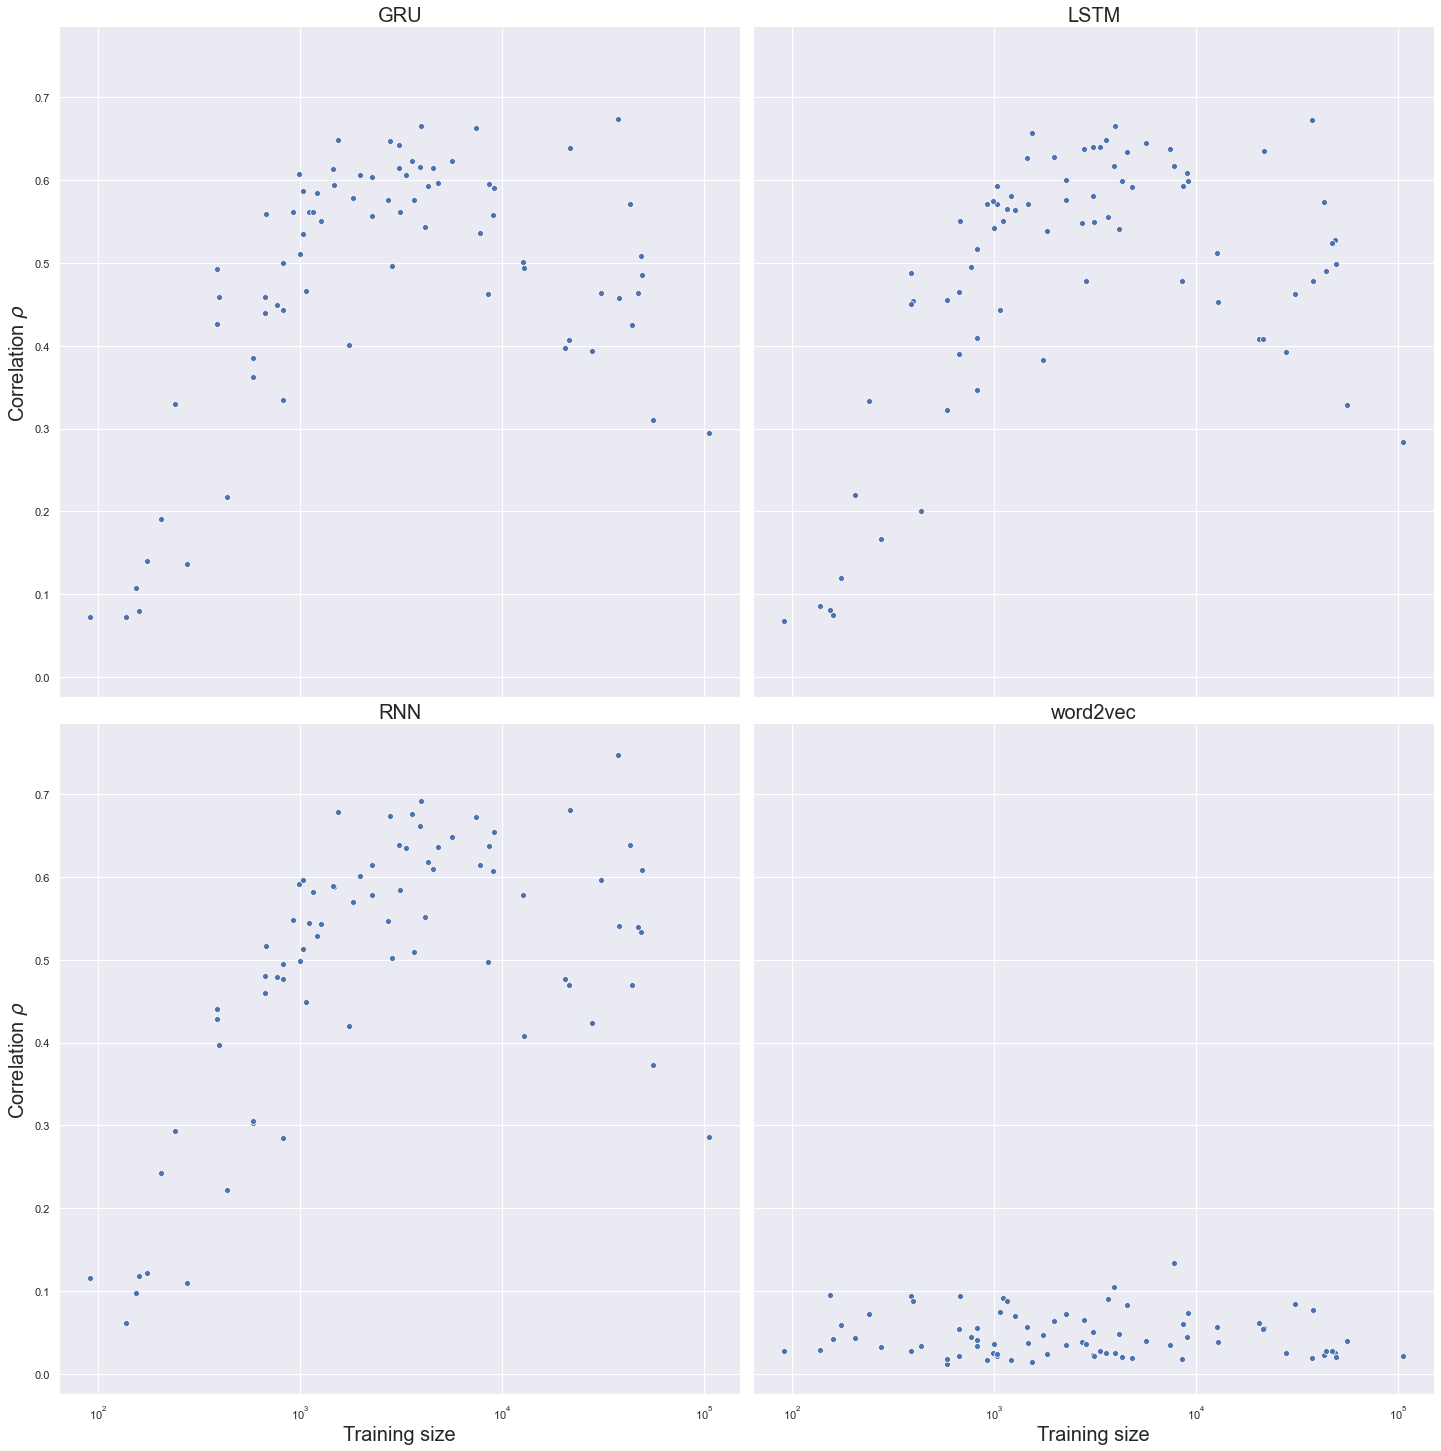

In [122]:
relationship_between_correlation_and_hyperparams_subset(
    [5, 10, 20, 30], ["rnn", "lstm", "gru", "word2vec"], "name"
);

Much like the performance analysis, training size is strongly correlated with the "human-likeness" of the representations. Interestingly, this is only true for the RNN models, as word2vec does not show any trend, regardless of window size.

## Do they learn interpretable representations?

Now I am interested in the extent to which the individual ground truth features are captured by the models. To do this, I use QVEC-CCA.

In [116]:
# Read in qvec results
models = all_trained_phoneme_models()
results = []
for model in tqdm(models):
    if model["size"] != "groundTruth":
        lg, name, epoch = model["lg"], model["name"], model["epoch"]
        if "hidden" in model:
            hyperparams = f"{model['size']}-{model['hidden']}"
        else:
            hyperparams = f"{model['size']}-{model['window']}"
        filename = f"results/phoneme/qvec/{lg}/{name}/{hyperparams}/{epoch}.txt"
        try:
            with open(filename) as file:
                model["r"] = file.read()
            results.append(model)
        except FileNotFoundError:
            continue
df = pd.DataFrame(results)
df["r"] = df["r"].astype(float)
df["n"] = df["lg"].apply(training_size)
for column in ["level", "lg", "name"]:
    df[column] = df[column].astype("category")
for column in ["size", "epoch", "n"]:
    df[column] = df[column].astype(int)
df

100%|██████████| 60842/60842 [00:00<00:00, 131846.65it/s]


,level,lg,name,size,hidden,epoch,r,n
0,phoneme,khm,gru,30,20,0,0.919338,2714
1,phoneme,khm,gru,30,20,1,0.919338,2714
2,phoneme,khm,gru,30,20,2,0.919338,2714
3,phoneme,khm,gru,30,20,3,0.919338,2714
4,phoneme,khm,gru,30,20,4,0.919338,2714
...,...,...,...,...,...,...,...,...
4450,phoneme,alb,rnn,10,20,8,0.880911,1064
4451,phoneme,alb,rnn,10,20,9,0.880911,1064
4452,phoneme,alb,rnn,20,5,0,0.798351,1064
4453,phoneme,alb,rnn,20,5,1,0.798351,1064


In [117]:
def relationship_between_qvec_and_hyperparams(sizes, names):
    # Restrict analysis to certain models
    size_restriction = df["size"].isin(sizes)
    model_restriction = df["name"].isin(names)
    subset = df[size_restriction & model_restriction]
    qvec_by_lg = subset.groupby("lg")[["r", "n"]].mean()
    fig, ax = plt.subplots(figsize=(14, 10))
    grid = sns.scatterplot(data=qvec_by_lg, x="n", y="r", ax=ax)
    grid.set(xscale="log");
    grid.set_ylabel("QVEC-CCA", fontsize=20)
    grid.set_xlabel("Training size", fontsize=20)
    return grid

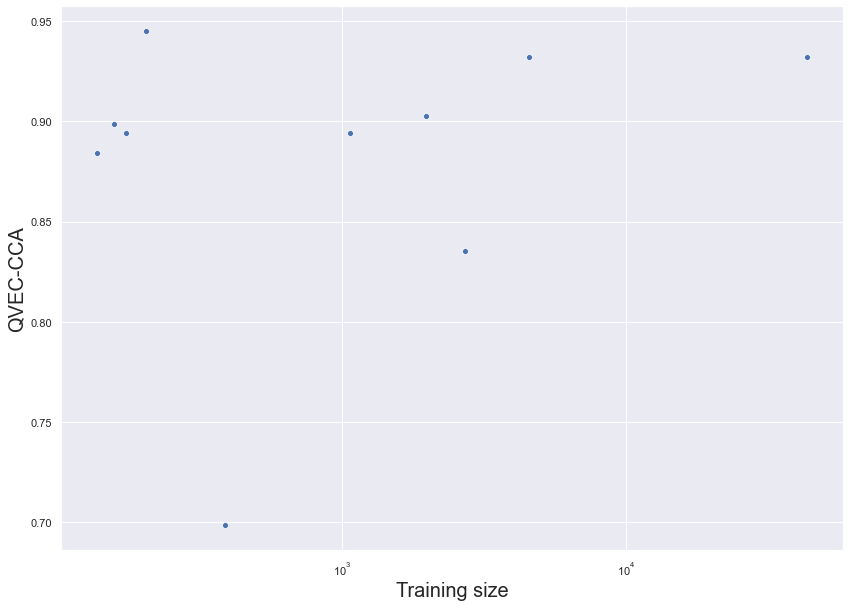

In [118]:
relationship_between_qvec_and_hyperparams([10, 20, 30], ["rnn", "lstm", "gru"]);

## Do they structure the space in a similar way to phonological features?

I use analogies to answer this question.

In [7]:
# Read in analogy results
models = all_trained_phoneme_models()
results = []
for model in tqdm(models):
    if model["size"] != "groundTruth":
        lg, name, epoch = model["lg"], model["name"], model["epoch"]
        if "hidden" in model:
            hyperparams = f"{model['size']}-{model['hidden']}"
        else:
            hyperparams = f"{model['size']}-{model['window']}"
        filename = f"results/phoneme/analogy/{lg}/{name}/{hyperparams}/{epoch}.csv"
        try:
            df = pd.read_csv(filename)
            df["lg"] = lg
            df["name"] = name
            df["epoch"] = epoch
            df["size"] = model["size"]
            results.append(df)
        except FileNotFoundError:
            continue
df = pd.concat(results, ignore_index=True, sort=False)
df["n"] = df["lg"].apply(training_size)
for column in ["lg", "name"]:
    df[column] = df[column].astype("category")
for column in ["size", "epoch", "n"]:
    df[column] = df[column].astype(int)
df

100%|██████████| 21587/21587 [00:07<00:00, 2944.52it/s]


,a,b,c,d,ft,rank,lg,name,epoch,size,n
0,b,p,dz̺,ts̺,voi,-1,cat,gru,0,10,43200
1,b,p,dz̺,t̠ʃ,voi,-1,cat,gru,0,10,43200
2,b,p,d̠ʒ,ts̺,voi,-1,cat,gru,0,10,43200
3,b,p,d̠ʒ,t̠ʃ,voi,-1,cat,gru,0,10,43200
4,b,p,d̪,t̪,voi,18,cat,gru,0,10,43200
...,...,...,...,...,...,...,...,...,...,...,...
170015,e,æu,eu,æu,lo,-1,ayl,lstm,8,10,137
170016,eu,æ,eu,æi,lo,-1,ayl,lstm,8,10,137
170017,eu,æ,eu,æu,lo,-1,ayl,lstm,8,10,137
170018,eu,æi,eu,æu,lo,-1,ayl,lstm,8,10,137


### Training data

In [38]:
numbers = merged[["lg", "n"]].drop_duplicates("lg").sort_values(by="n", ascending=False)
numbers.columns = ["Language", "Train"]
numbers["Validation"] = ((numbers["Train"] / 0.8) * 0.1).astype(int)
numbers["Test"] = ((numbers["Train"] / 0.8) * 0.1).astype(int)
numbers

,Language,Train,Validation,Test
14717,cmn_hani,106186,13273,13273
11864,pol,55648,6956,6956
35181,fre,49053,6131,6131
39322,eng_uk,48830,6103,6103
33223,spa_ca,47126,5890,5890
...,...,...,...,...
14117,ukr,174,21,21
2663,aze_latn,158,19,19
7340,ban,154,19,19
891,ayl,137,17,17


In [46]:
codes = pd.read_csv("data/phoneme/codes.tsv", sep="\t", header=None)
codes

,0,1,2,3,4,5,6
0,ady_phonetic.tsv,ady,Adygei; Adyghe,Adyghe,True,Phonetic,4725
1,afr_phonemic.tsv,afr,Afrikaans,Afrikaans,True,Phonemic,1148
2,afr_phonetic.tsv,afr,Afrikaans,Afrikaans,True,Phonetic,120
3,alb_phonemic.tsv,alb,Albanian,Albanian,True,Phonemic,1194
4,alb_phonetic.tsv,alb,Albanian,Albanian,True,Phonetic,740
...,...,...,...,...,...,...,...
231,yid_phonemic.tsv,yid,Yiddish,Yiddish,False,Phonemic,188
232,yid_phonetic.tsv,yid,Yiddish,Yiddish,False,Phonetic,325
233,zza_phonetic.tsv,zza,Zaza,Zazaki,True,Phonetic,177
234,zha_phonemic.tsv,zha,Zhuang,Zhuang,True,Phonemic,367


In [49]:
codes[codes[1].str.contains("cmn")]

,0,1,2,3,4,5,6
31,cmn_hani_phonemic.tsv,cmn,Mandarin Chinese,Chinese (Han),False,Phonemic,117991
